In [1]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error')

In [2]:
#training sets
with open('train.en') as f:
    train_en = [l.strip() for l in f.readlines()]
with open('train.fr') as f:
    train_fr = [l.strip() for l in f.readlines()]

#validation sets
with open('val.en') as f:
    val_en = [l.strip() for l in f.readlines()]
with open('val.fr') as f:
    val_fr = [l.strip() for l in f.readlines()]

#test sets
with open('test_2017_flickr.en') as f:
    test_en = [l.strip() for l in f.readlines()]
with open('test_2017_flickr.fr') as f:
    test_fr = [l.strip() for l in f.readlines()]

In [3]:
#TODO
# 0 PAD - padding 0 for convenience in masking
# 1 BOS - beginning of sentence
# 2 EOS - end of sentence
# 3 UNK - unknown

In [4]:
max_sentence_length = 50

In [5]:
def tokens_sentences(sentences):
    tokens_list = []
    sentence_list = []
    for s in sentences:
        split_sent = s.split()
        sentence = []
        for w in split_sent:

            tokens_list.append(w)
            sentence.append(w)

        sentence_list.append(sentence)
    
    return tokens_list, sentence_list

In [6]:
tokens_list_en, sentence_list_en = tokens_sentences(train_en)

tokens_train_en = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_en.extend(list(sorted(set(tokens_list_en))))
vocab_size_en = len(tokens_train_en)
print('Vocabulary size EN', vocab_size_en)

count_tokens_train_en = Counter(tokens_list_en)

tokens_list_fr, sentence_list_fr = tokens_sentences(train_fr)

tokens_train_fr = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_fr.extend(list(sorted(set(tokens_list_fr))))
vocab_size_fr = len(tokens_train_fr)
print('Vocabulary size FR', len(tokens_train_fr))

count_tokens_train_fr = Counter(tokens_list_fr)

Vocabulary size EN 15460
Vocabulary size FR 17007


In [7]:
def get_id_dicts(tokens):
    #default dictionary key:id value:token
    id2tokens = defaultdict(str)

    for i in range(len(tokens)):
        id2tokens[i] = tokens[i]

    #default dictionary key:token value:id
    tokens2id = defaultdict(int)

    for ind in id2tokens:
        tokens2id[id2tokens[ind]] = ind

    return tokens2id, id2tokens

In [8]:
tokens2id_en, id2tokens_en = get_id_dicts(tokens_train_en)

vocabulary_size_train_en = len(tokens2id_en)
print(vocabulary_size_train_en)

tokens2id_fr, id2tokens_fr = get_id_dicts(tokens_train_fr)

vocabulary_size_train_fr = len(tokens2id_fr)
print(vocabulary_size_train_fr)

15460
17007


In [9]:
def convert_corpus2id(sentence_list, tokens2id):
    
    #convert dataset to ids
    corpus2id = []
    
    for s in sentence_list:
    
        sentence2id = []
        sentence2id.append(tokens2id['<SOS>'])
    
        for w in s:
            word_id = tokens2id[w]
            sentence2id.append(word_id)
        
        
        sentence2id.append(tokens2id['<EOS>'])
        corpus2id.append(sentence2id)
    
    return corpus2id

In [10]:
corpus2id_en = convert_corpus2id(sentence_list_en, tokens2id_en)
corpus2id_fr = convert_corpus2id(sentence_list_fr, tokens2id_fr)

In [11]:
corpus2id_en[0]

[1, 2021, 15433, 2129, 8939, 2555, 9954, 9572, 8983, 3797, 2]

epoch, total loss, average loss, duration
0 718.2738318443298 718.273831844 0:00:02.183473
1 539.3672485351562 628.82054019 0:00:02.072869
2 516.5926432609558 591.411241213 0:00:02.061070
3 510.5496530532837 571.195844173 0:00:02.071433
4 509.6339201927185 558.883459377 0:00:02.044972
5 509.70082807540894 550.68635416 0:00:02.038153
6 509.78446865081787 544.843227659 0:00:02.050906
7 509.79284143447876 540.461929381 0:00:02.067501
8 509.7725043296814 537.051993264 0:00:02.035385
9 509.7488212585449 534.321676064 0:00:02.051614


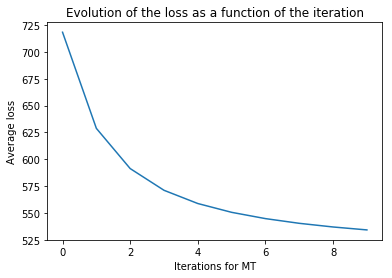

In [12]:
class Encoder(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length):
        super(Encoder, self).__init__()
        
        self.vocab_size_fr = vocab_size_fr
        self.max_sentence_length = max_sentence_length
        self.w_embedding_dim = w_embedding_dim
        self.p_embedding_dim = p_embedding_dim
        
        self.dec_embedding_dim = dec_embedding_dim
        
        #encoder
        self.w_embeddings = nn.Embedding(self.vocab_size_fr, self.w_embedding_dim)
        self.p_embeddings = nn.Embedding(self.max_sentence_length, self.p_embedding_dim)
        
        self.context_emb_dim = self.w_embedding_dim + self.p_embedding_dim
        
        self.average_projection = nn.Linear(self.context_emb_dim, self.dec_embedding_dim)
        
        self.attention_projection = nn.Linear(self.context_emb_dim, self.dec_embedding_dim)
        #do we use non-linearity after attention
        
        #TODO: DROPOUT
        
        
    def forward(self, sent_fr, pos_fr):
        
        #embedded = self.embedding(input).view(1, 1, -1)
        #TODO:BATCH
        
        ws = []
        ps = []
        es = []
        
        for s in range(len(sent_fr)):
            word = sent_fr[s]
            pos = pos_fr[s]
            
            w_out = self.w_embeddings(word)

            p_out = self.p_embeddings(pos)

            e_out = torch.cat((w_out, p_out), 0)
    
            ws.append(w_out)
            ps.append(p_out)
            es.append(e_out)
        
        stacked_contexts = torch.stack(es, dim = 0)
        average_context = torch.mean(stacked_contexts, dim = 0)
        average_context = self.average_projection(average_context)
        
        stacked_contexts = self.attention_projection(stacked_contexts)
            
        return average_context, stacked_contexts

class Decoder(nn.Module):
    def __init__(self, dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob):
        super(Decoder, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.max_sentence_length = max_sentence_length
        
        self.dec_embedding_dim = dec_embedding_dim
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        self.embedding = nn.Embedding(self.vocab_size_en, self.dec_embedding_dim)
        
        self.rnn = nn.RNN(self.dec_embedding_dim, self.dec_embedding_dim)
        #self.bidirLSTM = nn.LSTM(self.embedding_dim, self.embedding_dim, bidirectional=True)
        #TODO: LSTM, GRU 
       
        #a linear layer after this before softmax
        self.out_affine = nn.Linear(self.dec_embedding_dim, self.vocab_size_en)
               
    
    def forward(self, gold_target_sent, encoder_avg_context, encoder_stacked_contexts):
        
        pred = []
        attentions = []
        
        for s in range(len(gold_target_sent)):
            gold_word = gold_target_sent[s]
            
            output = self.embedding(gold_word)

            #g_out = self.dropout(g_out)
            
            if s == 0:
            
                #TODO: how to add weighted context
                #do we set h0 to avg context OR do we input it?
                output, hidden = self.rnn(output.view(1, 1, -1), encoder_avg_context.view(1, 1, -1))
                prev_hidden = hidden
                
                s_output = F.softmax(output[0], dim=0) #TODO: CHECK DIM AND OUTPUT[0]
                s_output = self.out_affine(s_output)
                pred.append(s_output)
                
            else:
                            
                #TODO: how to add weighted context
                output, hidden = self.rnn(output.view(1, 1, -1), prev_hidden.view(1, 1, -1))
                prev_hidden = hidden
                
                s_output = F.softmax(output[0], dim=0) #TODO: CHECK DIM AND OUTPUT[0]
                s_output = self.out_affine(s_output)
                pred.append(s_output)
                
            attention_weights_word = F.softmax(torch.matmul(encoder_stacked_contexts, prev_hidden.view(-1,1)), dim = 0)
            attentions.append(attention_weights_word)
            
        attention_weights = torch.stack(attentions, dim=0)
            
        pred = torch.stack(pred, dim=0)
        return pred, attention_weights #output, hidden 

    
    #https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

epochs = 10
learning_rate = 0.01
w_embedding_dim = 10
p_embedding_dim = 10
dec_embedding_dim = 10
dropout_prob = 0.1

model_encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
model_decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)

optimizer_encoder = optim.Adam(model_encoder.parameters(), lr = learning_rate)
optimizer_decoder = optim.Adam(model_decoder.parameters(), lr = learning_rate)

loss_func = nn.CrossEntropyLoss()
losses = []
avg_losses = []

portion = 100

print('epoch, total loss, average loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for s in range(portion):
 
        current_input = corpus2id_fr[s]
        gold_output = corpus2id_en[s]
        
        if len(current_input) > 0 and len(gold_output) > 0:
            
            sent_fr = torch.tensor(np.asarray(current_input), dtype= torch.long)
            sent_en = torch.tensor(np.asarray(gold_output), dtype= torch.long)

            pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
            pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))
           
            sent_fr_pos = torch.tensor(np.asarray(pos_fr), dtype= torch.long)            
            sent_en_pos = torch.tensor(np.asarray(pos_en), dtype= torch.long)
            
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()

            average_context, stacked_contexts = model_encoder(sent_fr, sent_fr_pos)
       
            #prev_hidden = average_context or actual prev_hidden
        
            pred, attention_weights = model_decoder(sent_en, average_context, stacked_contexts)
            
            loss = loss_func(pred.squeeze(), sent_en)
        
            loss.backward()

            optimizer_encoder.step()
            optimizer_decoder.step()

            total_loss += loss.item() 
        
    
    now = datetime.now()
        
    losses.append(total_loss)
    
    avg_loss = np.mean(losses)
    
    print(e, total_loss, avg_loss, now-then)
    
    avg_losses.append(avg_loss)
    

with open('model_encoder' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_encoder,file)
      

with open('model_decoder' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_decoder,file)
    
iteration= list(range(len(avg_losses)))

plt.plot(iteration, avg_losses)
plt.xlabel("Iterations for MT")
plt.ylabel('Average loss')
plt.title('Evolution of the loss as a function of the iteration')
plt.savefig("mt" + str(portion)+".png")
plt.show()

In [261]:
portion = 100

with open('model_encoder' + str(portion) + '.pickle','rb') as file:
    model_encoder = pickle.load(file)
      

with open('model_decoder' + str(portion) + '.pickle','rb') as file:
    model_decoder = pickle.load(file)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def visualize_attention(model, sentence):
    
#************************************************************************
# A is the attention torch Tensor: the output of your model
# S is the softmax version of S, also a torch Tensor! (actually more acurately it's a Variable(Tensor(..))
#************************************************************************

    # Plot the attention tensor
    plt.clf()
    numpy_S = S.data.numpy() # get the data in Variable, and then the torch Tensor as numpy array
    plt.imshow(numpy_S)
    plt.savefig("attention-sent-{}-epoch-{}".format(i, step))

In [ ]:
#TODO
#TEST - INFERENCE
#BEAM SEARCH

In [17]:
a = torch.tensor(np.asarray([i for i in range(10)]), dtype= torch.float)

In [18]:
b = torch.tensor(np.asarray([i+1 for i in range(10)]), dtype= torch.float)

In [20]:
st = torch.stack([a,b,a,b,a], dim = 0)
print(st)

tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
        [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
        [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
        [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
        [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]])


In [163]:
torch.stack([a,b], dim = 1)

tensor([[  0.,   1.],
        [  1.,   2.],
        [  2.,   3.],
        [  3.,   4.],
        [  4.,   5.],
        [  5.,   6.],
        [  6.,   7.],
        [  7.,   8.],
        [  8.,   9.],
        [  9.,  10.]])

In [164]:
torch.mean(st, dim = 1)

tensor([ 4.5000,  5.5000])

In [166]:
torch.mean(st, dim = 0)

tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,
         7.5000,  8.5000,  9.5000])

In [176]:
F.softmax(st, dim = 0)

tensor([[ 0.2689,  0.2689,  0.2689,  0.2689,  0.2689,  0.2689,  0.2689,
          0.2689,  0.2689,  0.2689],
        [ 0.7311,  0.7311,  0.7311,  0.7311,  0.7311,  0.7311,  0.7311,
          0.7311,  0.7311,  0.7311]])

In [13]:
a.view(-1,1)

NameError: name 'a' is not defined

In [35]:
weights = torch.tensor(np.array([[0.1],[0.2],[0.3],[0.4],[0.5]]))
st*weights

SyntaxError: keyword can't be an expression (<ipython-input-35-16e7787fa6bf>, line 1)

In [ ]:

#     attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                  encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         output = self.attn_combine(output).unsqueeze(0)
           
#         atts= torch.matmul(es, hidden_from_decoder)
        
#         weighted_context = es*attention_weights
        
        #if EOS for encoder, move on to the decoder
        
        #attention_matrices = self.attention_projection(e_out)
        
        #input embedding
        #set hidden at the beginning
        #get rnn output
        #apply softmax

        #feed actual word for training
        #feed previous word for testing

#             #view_shape = embeddings.shape[0]
#             output, (hidden, cell) = self.bidirLSTM(embeddings.view(1, 1, -1)) 

#             hid_f = hidden[0]
#             hid_b = hidden[1]